# Single-Subject EEG and iEEG Analysis of Memory Load: Time–Frequency Power Dynamics in Alpha, Beta, and Theta Bands

This experimental notebook cleans EEG and iEEG data, and conducts a time-frequency analysis on a single session for a subject that is undergoing a modified Sternberg task. This notebook is aimed at answering the following question based on the data provided:

**Is there evidence of memory item replay during maintenance, and does it scale with load?**

The objective of this notebook primarily exploratory, to gain hands-on experience with core EEG and iEEG preprocessing techniques such as:
* Bandpass filtering.
* Artifact removal using Independent Component Analysis (ICA).
* Epoching categorised by set size and excluding trials with artifacts.
* Time-frequency analysis resulting in power over time plots across alpha, beta, and theta bands.

The dataset is publicly available on [OpenNeuro](https://openneuro.org/datasets/ds004752/versions/1.0.1) cited as:
    
> Vasileios Dimakopoulos and Lennart Stieglitz and Lukas Imbach and Johannes Sarnthein (2023). Dataset of intracranial EEG, scalp EEG and beamforming sources from epilepsy patients performing a verbal working memory task. OpenNeuro. [Dataset] doi: doi:10.18112/openneuro.ds004752.v1.0.1

*Note: This notebook focuses on a single subject and session for exploration and learning. A more rigorous multi-subject pipeline, leveraging tools like autoreject for trial cleaning and broader statistical comparisons, is implemented in a separate notebook.*

**Table of Contents:**
* *1. Overview*
* *2. EEG: Understanding Data*
  * 2.1 Importing Libraries and Loading Data
  * 2.2 Reading Data and Checking for Null Values
* *3. EEG: Preprocessing*
  * 3.1 Bandpass Filtering and Bad Channel Rejection
  * 3.2 Independent Component Analysis (ICA)
  * 3.3 Epoching by Set Size
* *4. EEG: Analysis*
  * 4.1 Feature Extraction and Time-Frequency Analysis
  * 4.2 Alpha, Beta, and Theta Bands
* *5. iEEG: Understanding Data*
* *6. iEEG: Preprocessing*
* *7. iEEG: Analysis*
* *8. Conclusion*

## 1. Overview
This notebook utilised session data from subject 1 session 4, which was chosen arbitrarily to conduct exploratory single-session data analysis and attempt at artifact removal using independent component analysis (ICA). Preprocessing and analysis of alpha, beta, and theta band powers over time were conducted. While there was success in preprocessing with ICA and plotting power over time graphs, there were no conclusive results potentially due to limited samples or event-related issues regarding the dataset.

1. **Understanding Data**
* EEG and iEEG data are both split into a raw EDF file and several tsv files. All files contain no null values.
* Montage was set for both EEG and iEEG raw data. EEG followed the 10-20 system while coordinates had to be manually set for iEEG.

2. **Preprocessing**
* Notch filtering, bandpass filtering, Independent Component Analysis (ICA), epoching was conducted EEG data. Only bandpass filtering and epoching was conducted for iEEG data.
* It is noted that stim channels were not present for both raw datasets, requiring one to infer event markers based on the research article published based on the dataset.

4. **Analysis**
* Power/time plots based on alpha, beta, and theta frequency bins were conducted, categorised by set size, to identify correlations between power and cognitive load.
* Both EEG and iEEG data yielded little conclusive evidence of power increasing with cognitive load for alpha and theta waves, and decreasing with cognitive load for beta waves.

6. **Conclusion**
* While it was expected that EEG data was unlikely to yield conclusive results, there was surprise that little correlation was found in iEEG data as well.
* Potential limitations include the absence of stim channels in the dataset and the unclear link between task-described events and the way the event dataset was partitioned. Other limitaitions include unfamiliarity with setting montage or troubleshooting at this juncture.

## 2. EEG: Understanding Data
### 2.1 Importing Libraries and Loading Data
The dataset directory is structured as such:
```
ds004752/
├── CHANGES
├── dataset_description.json
├── derivatives/
│   ├── sub-01/
│   │   └── beamforming/
│   │       └── sub-01-task-verbalWM-LCMVsources.mat
│   └── ...
├── participants.json
├── participants.tsv
├── README
├── sub-01/
│   ├── ses-01/
│   │   ├── eeg/
│   │   │   ├── sub-01_ses-01_task-verbalWM_run-01_channels.tsv
│   │   │   ├── sub-01_ses-01_task-verbalWM_run-01_eeg.edf
│   │   │   ├── sub-01_ses-01_task-verbalWM_run-01_eeg.json
│   │   │   ├── sub-01_ses-01_task-verbalWM_run-01_events.json
│   │   │   └── sub-01_ses-01_task-verbalWM_run-01_events.tsv
│   │   ├── ieeg/
│   │   │   ├── sub-01_ses-01_task-verbalWM_run-01_channels.tsv
│   │   │   ├── sub-01_ses-01_task-verbalWM_run-01_electrodes.json
│   │   │   ├── sub-01_ses-01_task-verbalWM_run-01_electrodes.tsv
│   │   │   ├── sub-01_ses-01_task-verbalWM_run-01_events.json
│   │   │   ├── sub-01_ses-01_task-verbalWM_run-01_events.tsv
│   │   │   ├── sub-01_ses-01_task-verbalWM_run-01_ieeg.edf
│   │   │   └── sub-01_ses-01_task-verbalWM_run-01_ieeg.json
│   │   └── sub-01_ses-01_scans.tsv
│   ├── ...
│   └── sub-01_sessions.tsv
└── ...
```
The beamformed EEG data was not used since it is only accessible through MATLAB, whereas the objectives of this notebook is to familiarise oneself with the MNE library in Python as well as basic EEG preprocessing and analysis skills.

The dataset description, extracted from the README, is as follows:
> We present an electrophysiological dataset recorded from fifteen subjects during a verbal working memory task. Subjects were epilepsy patients undergoing intracranial monitoring for localization of epileptic seizures. Subjects performed a modified Sternberg task in which the encoding of memory items, maintenance, and recall were temporally separated. The dataset includes simultaneously recorded scalp EEG with the 10-20 system, intracranial EEG (iEEG) recorded with depth electrodes, waveforms, and the MNI coordinates and anatomical labels of all intracranial electrodes. The dataset includes also reconstructed virtual sensor data that were created by performing LCMV beamforming on the EEG at specific brain regions including, temporal superior lobe, lateral prefrontal cortex, occipital cortex, posterior parietal cortex, and Broca.  Subject characteristics and information on sessions (set size, match/mismatch, correct/incorrect, response, response time for each trial) are also provided. This dataset enables the investigation of working memory by providing simultaneous scalp EEG and iEEG recordings, which can be used for connectivity analysis, alongside reconstructed beamforming EEG sources that can enable further cognitive analysis such as replay of memory items.

This section loads the relevant libraries, MNE, Pandas, NumPy, and Matplotlib. Subject 1 session 4's EEG data contains 3 relevant files which were loaded, providing us with information on the raw data in EDF format, events and channels in tsv format. The ```set_montage('standard_1020')``` function was called to provide the raw data with information on the location of each electrode on the head in line with the 10-20 system.

In [1]:
import mne
mne.set_log_level('WARNING')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib qt

In [2]:
raw = mne.io.read_raw_edf('ds004752/sub-01/ses-04/eeg/sub-01_ses-04_task-verbalWM_run-01_eeg.edf', preload=True)
ev = pd.read_csv('ds004752/sub-01/ses-04/eeg/sub-01_ses-04_task-verbalWM_run-01_events.tsv', sep='\t')
ch = pd.read_csv('ds004752/sub-01/ses-04/eeg/sub-01_ses-04_task-verbalWM_run-01_channels.tsv', sep='\t')
raw.set_montage('standard_1020')

<RawEDF | sub-01_ses-04_task-verbalWM_run-01_eeg.edf, 19 x 80000 (400.0 s), ~11.6 MB, data loaded>

### 2.2 Reading Data and Checking for Null Values
This section plots the raw EEG data in a voltage over time graph to get a rough idea of the noise present and potential bad channels to drop in the preprocessing phase. A check to understand the structure of the events and channels tables were also conducted, both tables contain no null values.

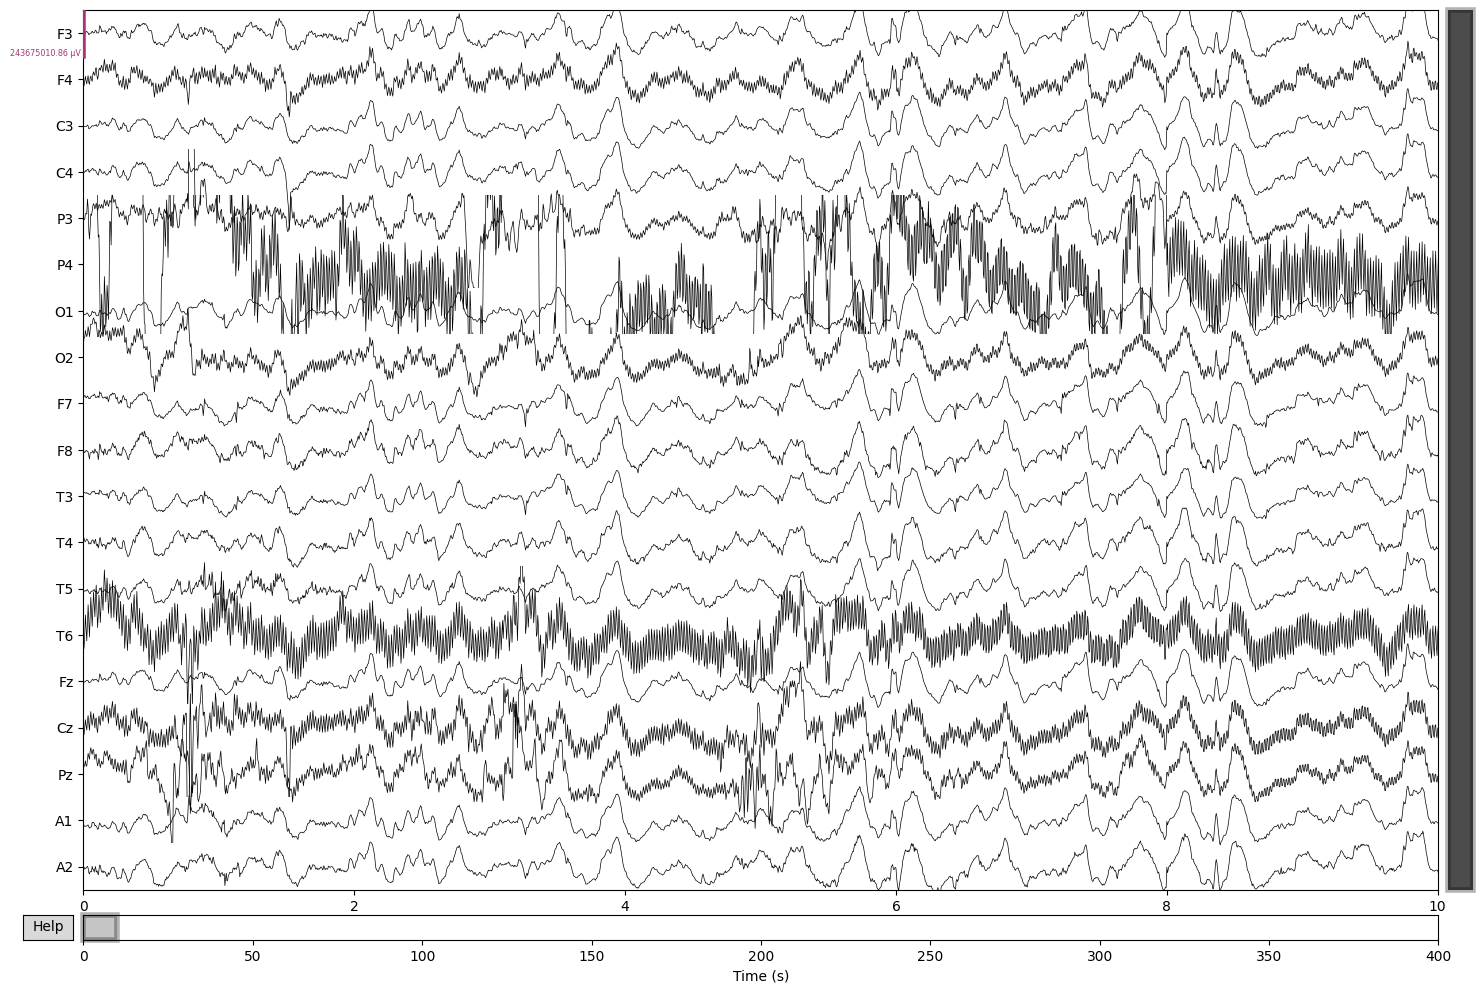

In [3]:
fig = raw.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()
fig

In [4]:
ev.head()

onset  duration  nTrial  begSample  endSample  SetSize ProbeLetter Match  \
0   0.005         8       1          1       1600        8           W    IN   
1   8.005         8       2       1601       3200        6           K    IN   
2  16.005         8       3       3201       4800        8           P    IN   
3  24.005         8       4       4801       6400        4           W   OUT   
4  32.005         8       5       6401       8000        4           P    IN   

   Correct  ResponseTime  Artifact  
0        1      1.178125         1  
1        1      1.400250         0  
2        1      1.293250         0  
3        1      1.422375         0  
4        1      0.918375         0

In [5]:
ev[ev.isnull()].count()

onset           0
duration        0
nTrial          0
begSample       0
endSample       0
SetSize         0
ProbeLetter     0
Match           0
Correct         0
ResponseTime    0
Artifact        0
dtype: int64

In [6]:
ch.head()

name type units  low_cutoff  high_cutoff  sampling_frequency
0   F3  EEG    μV        1000          0.5                 200
1   F4  EEG    μV        1000          0.5                 200
2   C3  EEG    μV        1000          0.5                 200
3   C4  EEG    μV        1000          0.5                 200
4   P3  EEG    μV        1000          0.5                 200

In [7]:
ch[ch.isnull()].count()

name                  0
type                  0
units                 0
low_cutoff            0
high_cutoff           0
sampling_frequency    0
dtype: int64

## 3. EEG: Preprocessing
### 3.1 Bandpass Filtering and Bad Channel Rejection
This section mainly conducts notch filtering, bandpass filtering, and dropping of bad channels after looking at the voltage frequency plot and assessing variance per channel. Having plotting the Power Spectrum Density, we can note that there is a major spike in power at the 50Hz mark likely attributed to power line noise. This encourages us to apply notch filtering at the 50Hz frequency and bandpass filtering to achieve the desired frequency range and ignore other potential noise due to artifacts. The EEG reference is also set to average.

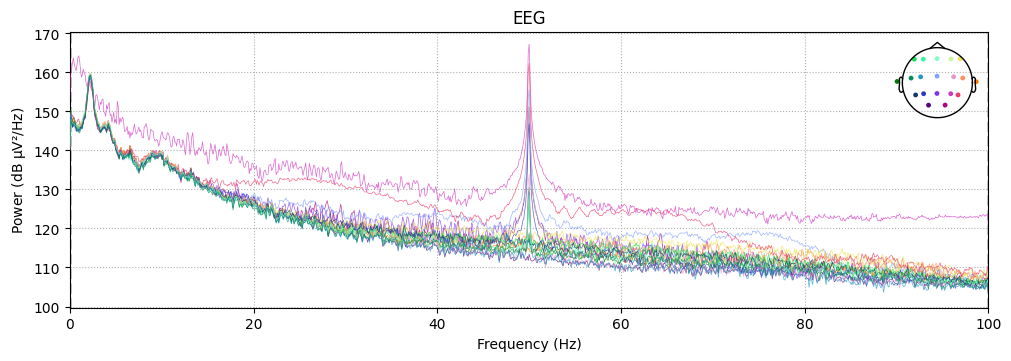

In [8]:
raw.plot_psd()

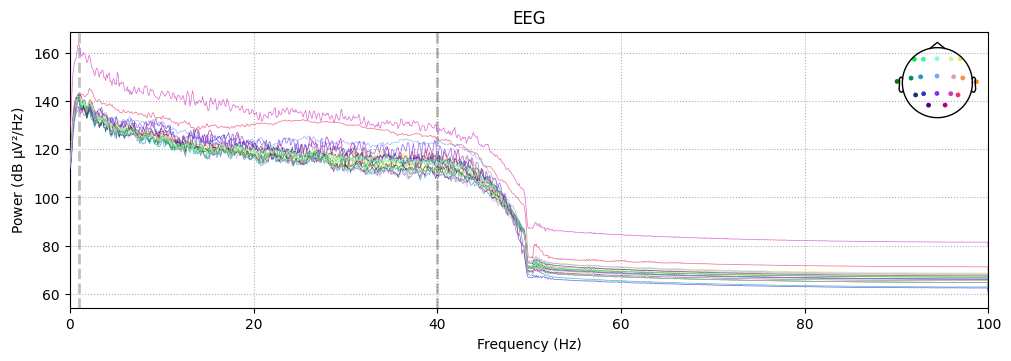

In [9]:
raw.notch_filter(freqs=50)
raw.filter(1., 40.)
raw.set_eeg_reference('average')
raw.plot_psd()

We can note here that the PSD no longer exhibits the sudden power spike and has the frequencies 40Hz and above filtered, resulting in a more stable PSD plot. Having looked at the voltage over time plot of the raw data earlier, P4 has a wave which looks noisy and disconnected, O2 also shows indication of some instability, coupled with evidence of a dying signal in earlier ICA iterations, encourage us to drop both of those channels before proceeding.

In [10]:
data = raw.get_data()
variances = np.var(data, axis=1)

for ch_name, var in zip(raw.ch_names, variances):
    print(f"{ch_name}: {var:.2e}")

F3: 2.09e+02
F4: 2.33e+02
C3: 1.37e+02
C4: 1.70e+02
P3: 3.47e+02
P4: 2.27e+04
O1: 1.82e+02
O2: 2.96e+02
F7: 2.65e+02
F8: 2.93e+02
T3: 1.70e+02
T4: 2.77e+02
T5: 1.62e+02
T6: 8.73e+02
Fz: 2.57e+02
Cz: 3.20e+02
Pz: 2.19e+02
A1: 1.86e+02
A2: 2.25e+02


In [11]:
raw.drop_channels(['P4', 'O2'])

<RawEDF | sub-01_ses-04_task-verbalWM_run-01_eeg.edf, 17 x 80000 (400.0 s), ~10.4 MB, data loaded>

### 3.2 Independent Component Analysis (ICA)
This section conducts Independent Component Analysis (ICA) where the raw data is split into separate components and noisy components (likely containing artifacts) are rejected. A topographical plot of the various components are shown, along with the voltage/time plots of the components.

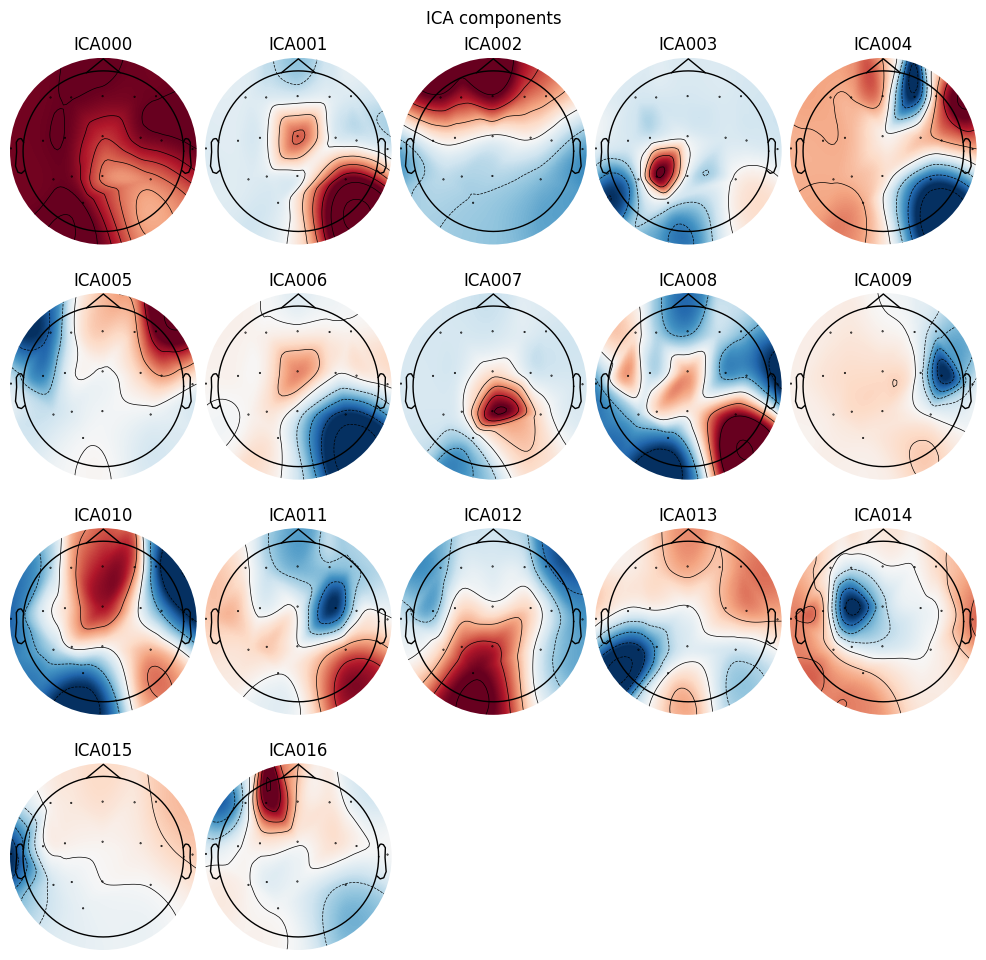

In [12]:
ica = mne.preprocessing.ICA(n_components=17, random_state=42)
ica.fit(raw)
ica.plot_components()

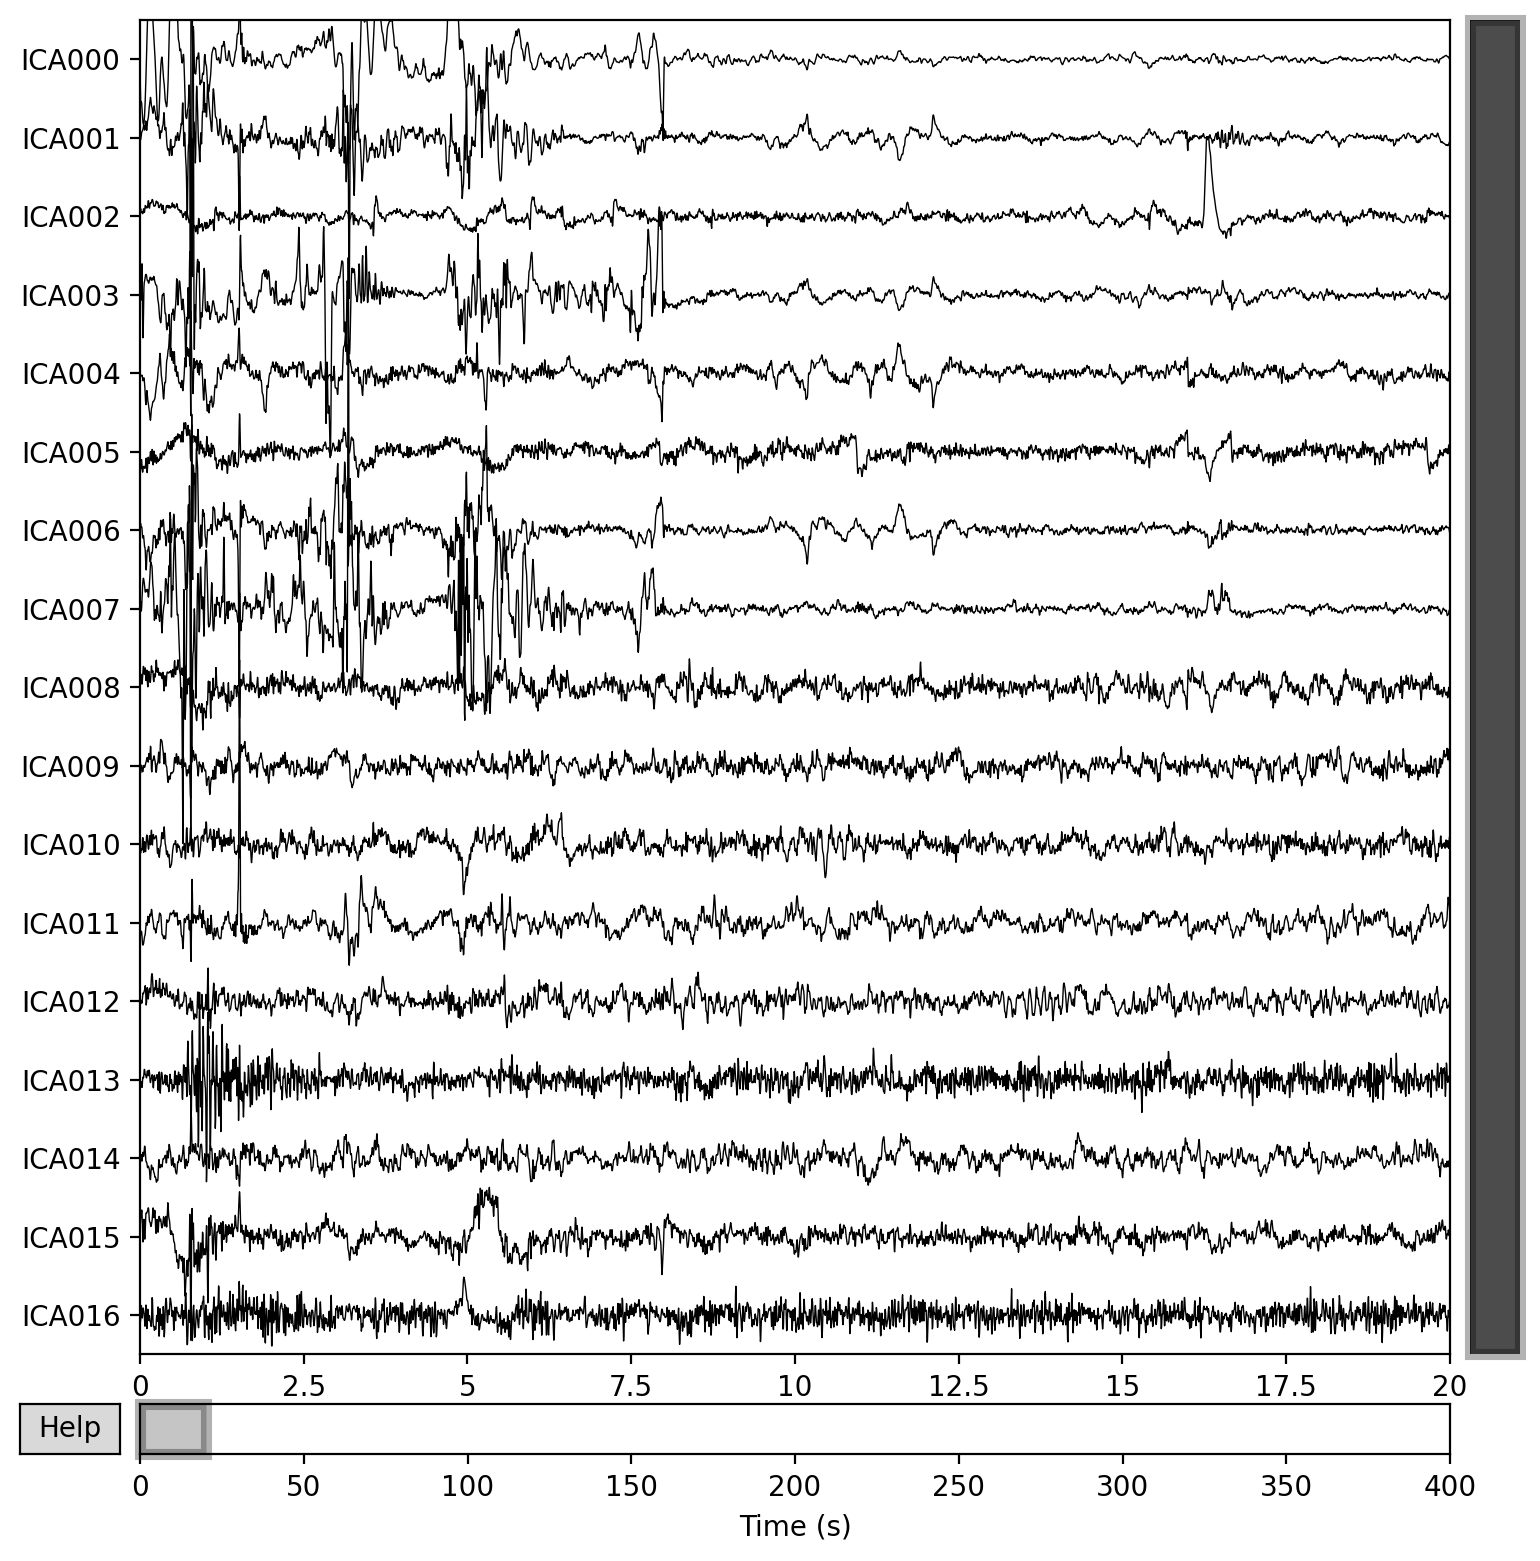

In [13]:
ica.plot_sources(raw)

We can note from the topographical plots that 0 and 2 are likely eye blink artifacts due to the high noise at the frontal region. Plots 5 is likely lateral eye movement artifacts due to the high noise on both sides of the frontal region. The other plots are likely muscle artifacts due to the high noise isolated to edges of the head.

We can exclude those plots and overlay the cleaned EEG data over the original data to see if there are any tangible improvements to the signal.

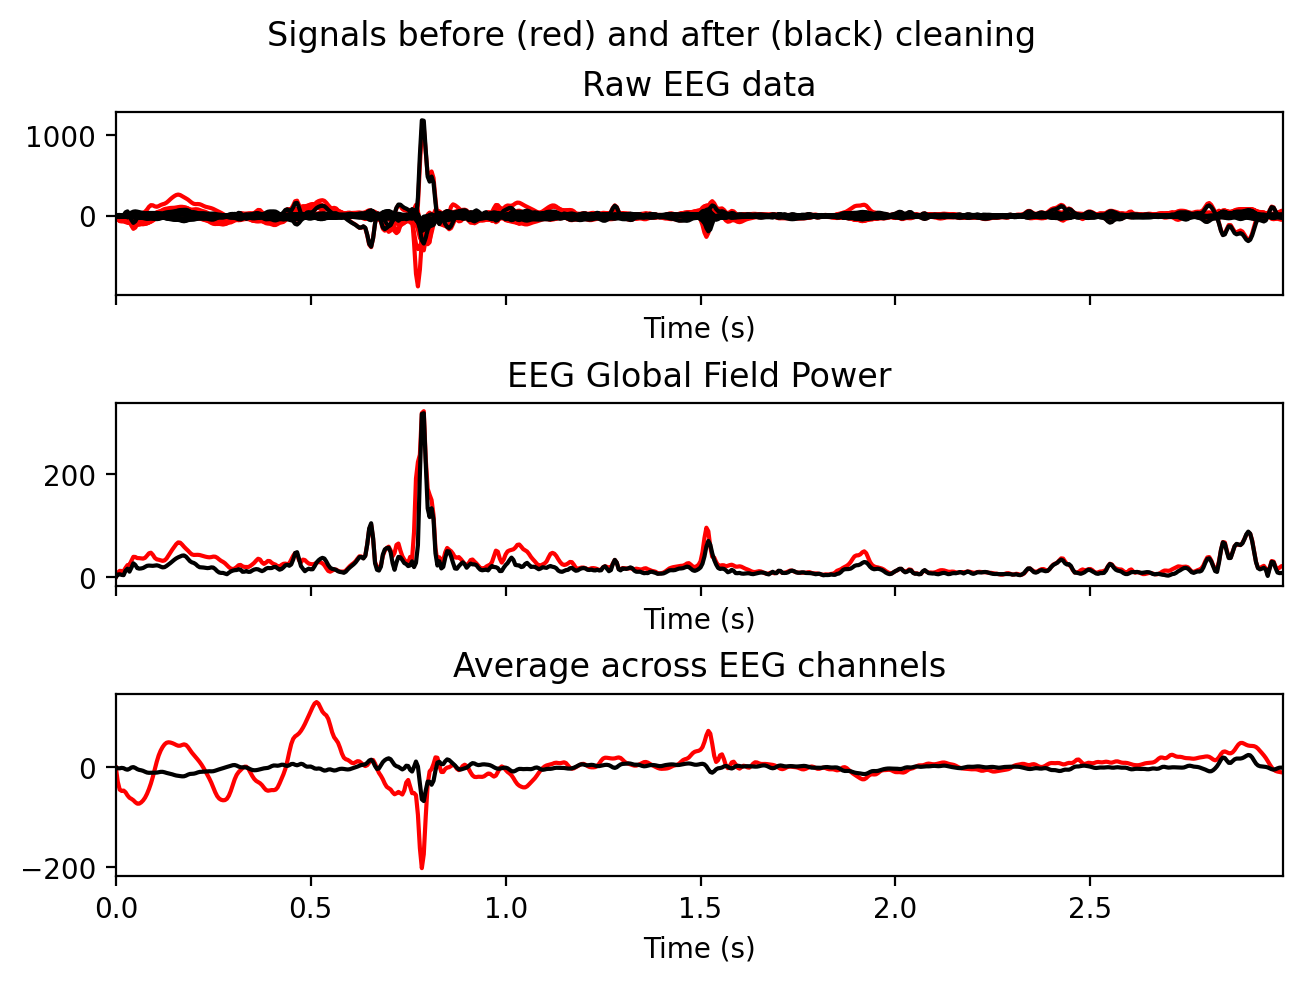

In [14]:
ica.exclude = [0, 1, 2, 5, 6, 9, 15]
ica.plot_overlay(raw)

Having seen considerable improvement due to the removal of noise and erratic spikes in the signal, we can apply the new signal with relevant components removed to the raw data and begin epoching.

In [15]:
ica.apply(raw)

<RawEDF | sub-01_ses-04_task-verbalWM_run-01_eeg.edf, 17 x 80000 (400.0 s), ~10.4 MB, data loaded>

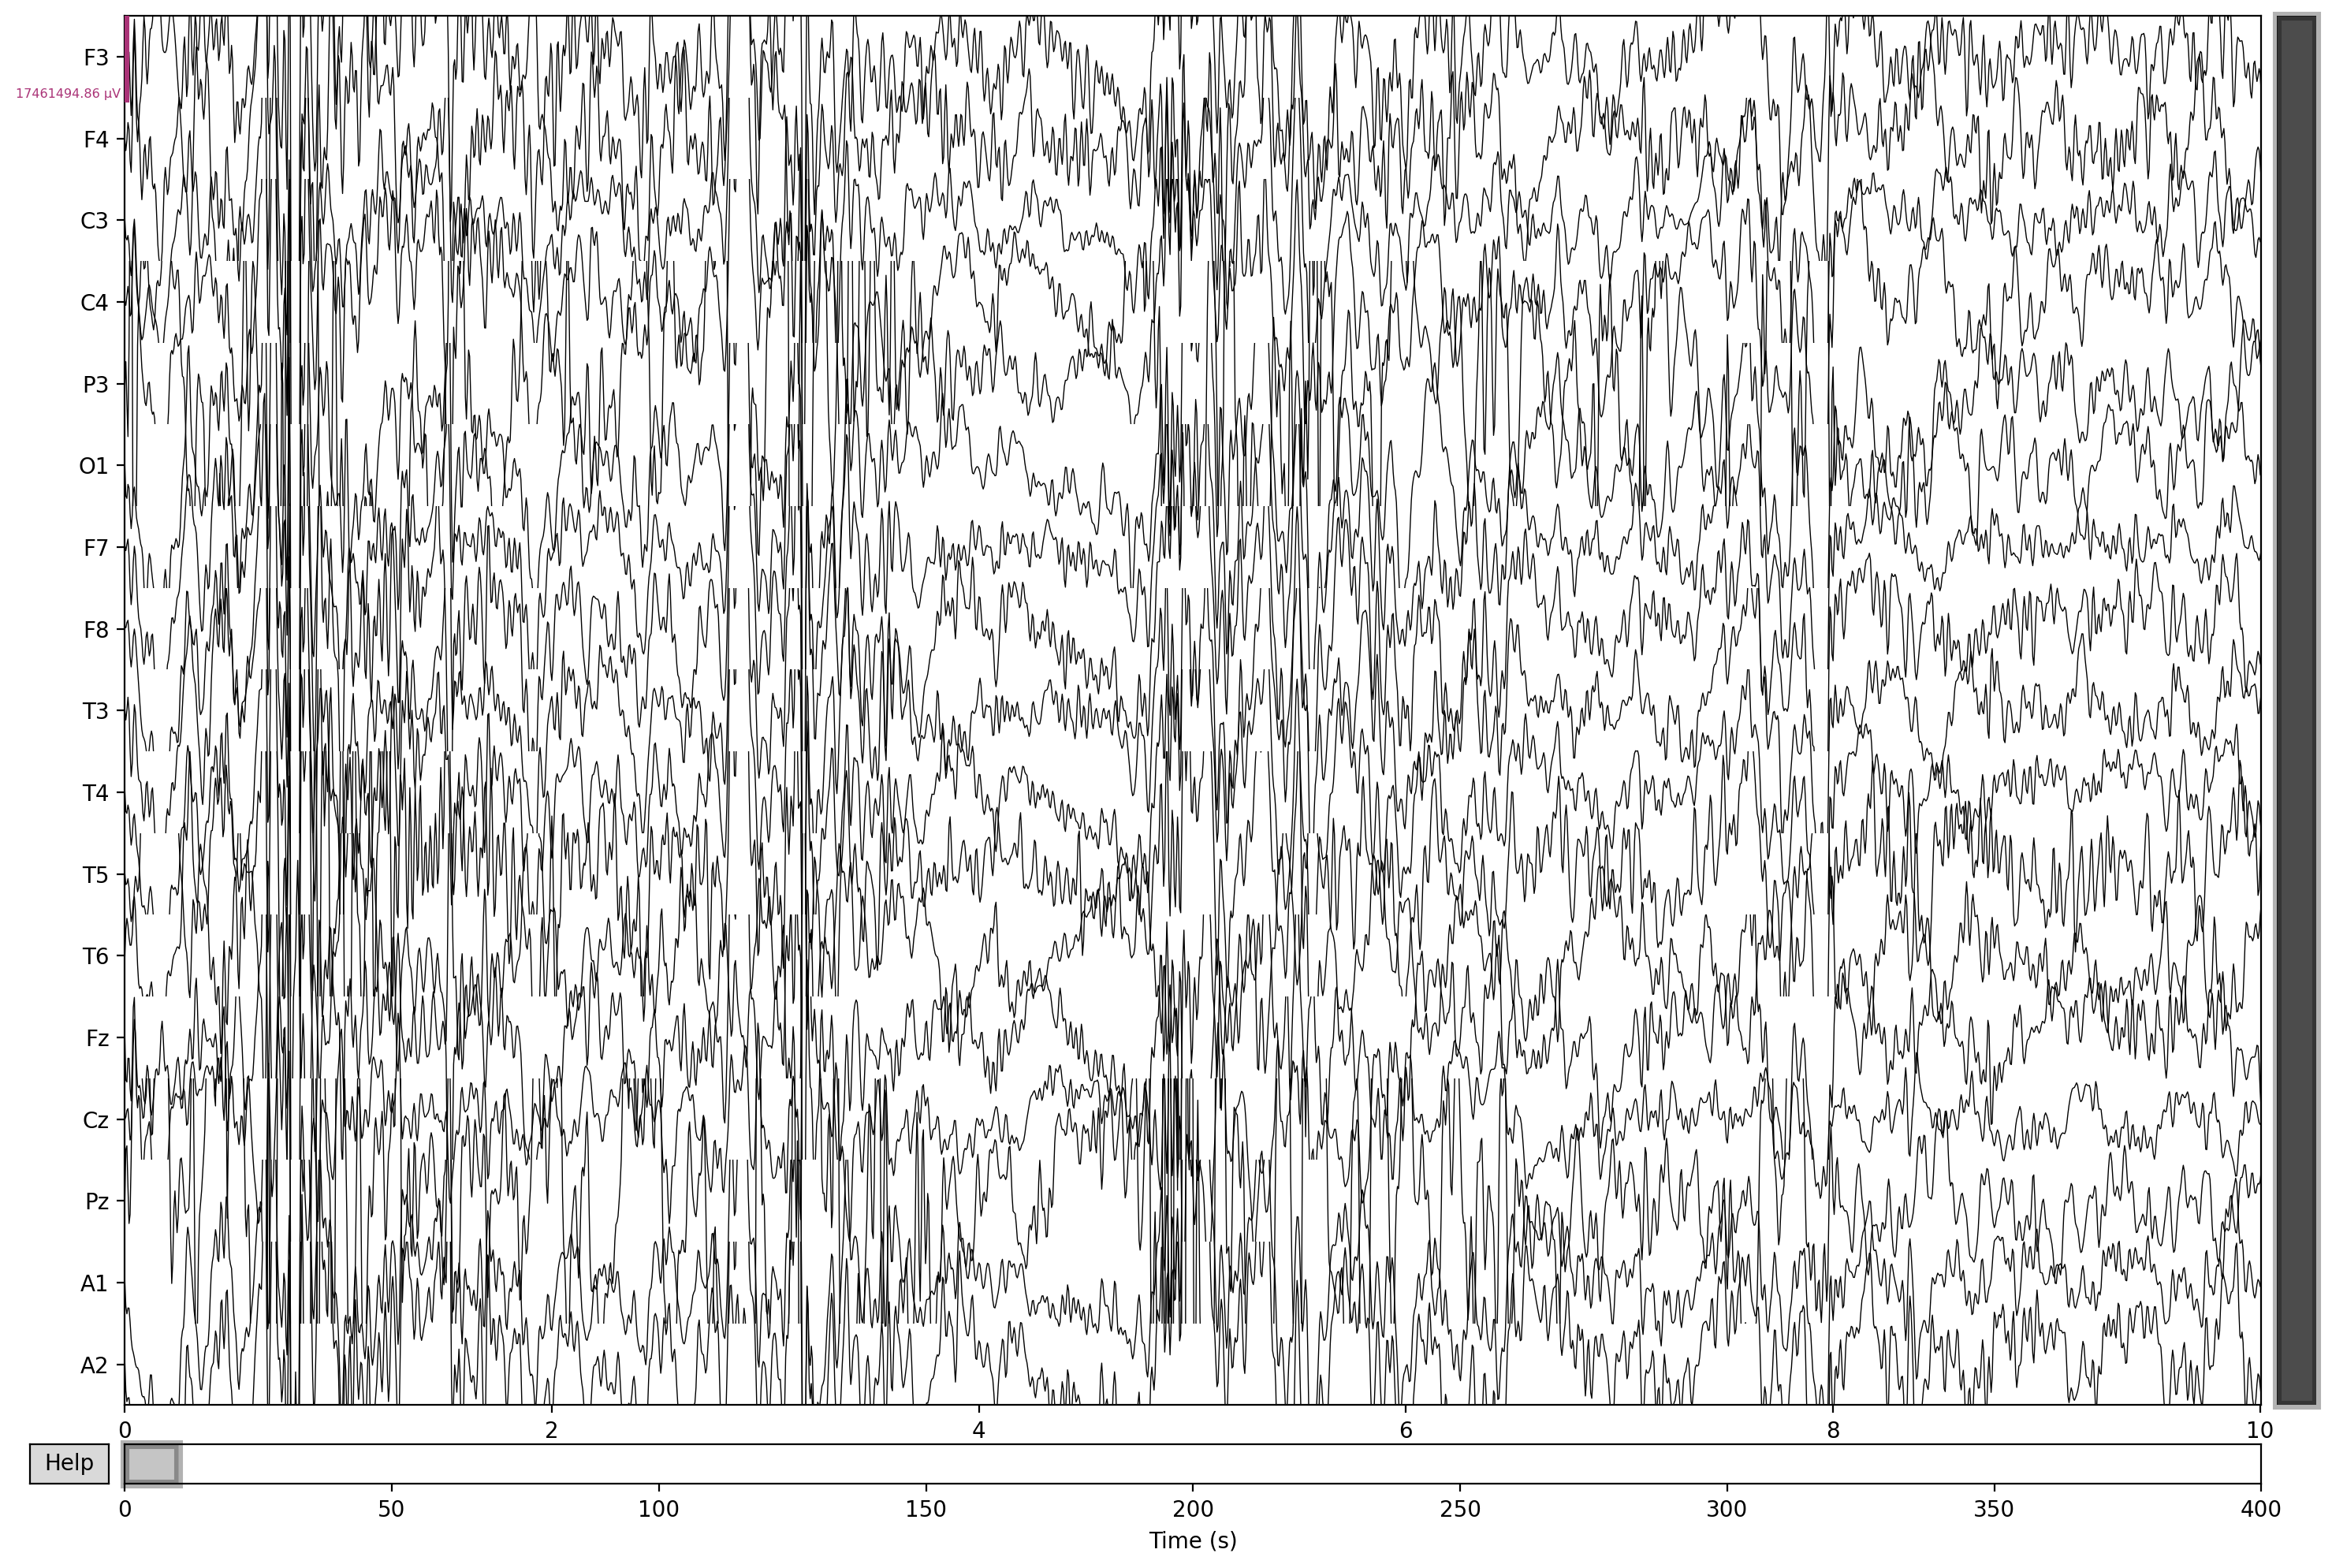

In [16]:
fig = raw.plot(scalings='auto', show=False)
fig.set_size_inches(15, 10)
plt.show()
fig

### 3.3 Epoching by Set Size

A description of the task resulting in the dataset is extracted from the published article [(Dimakopoulos, 2022)](https://elifesciences.org/articles/78677), is outlined as such:

> We used a modified Sternberg task in which the encoding of memory items and their maintenance was temporally separated (Figure 1a). Each trial started with a fixation period ([−6, –5] s), followed by the stimulus ([−5, –3] s). The stimulus consisted of a set of eight consonants at the center of the screen. The middle four, six, or eight letters were the memory items, which determined the set size for the trial (4, 6, or 8 respectively). The outer positions were filled with ‘X’, which was never a memory item. The participants read the letters and heard them spoken at the same time. After the stimulus, the letters disappeared from the screen, and the maintenance interval started ([−3, 0] s). Since the auditory encoding may have extended beyond the 2 s period, we restrict our analysis to the last 2 s of the maintenance period ([−2, 0] s). A fixation square was shown throughout fixation, encoding, and maintenance. After maintenance, a probe was presented. The participants responded with a button press to indicate whether the probe was part of the stimulus. The participants were instructed to respond as rapidly as possible without making errors. After the response, the probe was turned off, and the participants received acoustic feedback regarding whether the response was correct or incorrect. The participants performed sessions of 50 trials in total, which lasted approximately 10 min each. Trials with different set sizes were presented in a random order, with the single exception that a trial with an incorrect response was always followed by a trial with a set size of 4.

Having inspected the RAW data, we can note that there are no STIM channels included in the dataset itself. This means that we have to infer within each 8 second trial, when the encoding, maintenance, and probing occurs. Considering the fixation period is 1s, stimulus is 2s, maintenance is 3s, and probing is described at the 0s mark, since the onset information of the event dataset seems to indicate the start of each trial rather than the onset of the probe, this proves to be slightly confusing. We infer that the maintenance period starts at the 4s mark assuming fixation [1, 2] and stimulus [2, 4].

In [17]:
len(mne.pick_types(raw.info, stim=True))

0

In [18]:
ev.head()

onset  duration  nTrial  begSample  endSample  SetSize ProbeLetter Match  \
0   0.005         8       1          1       1600        8           W    IN   
1   8.005         8       2       1601       3200        6           K    IN   
2  16.005         8       3       3201       4800        8           P    IN   
3  24.005         8       4       4801       6400        4           W   OUT   
4  32.005         8       5       6401       8000        4           P    IN   

   Correct  ResponseTime  Artifact  
0        1      1.178125         1  
1        1      1.400250         0  
2        1      1.293250         0  
3        1      1.422375         0  
4        1      0.918375         0

Considering that set sizes discretely vary between 4, 6, and 8, and that trials with artifacts are properly marked, we can segment the event data based on set size and remove all trials marked with artifacts.

Due to the lack of stim channels, we have to manually get events (structered as ```[name_of_segment, 0, id]``` from the tsv file along with the event IDs (structured ```{segment1: id_num, segment2: id_num, segment3: id_num}```). After creating event arrays and event_ids based on the available information, we can get epochs for set sizes 4, 6, and 8.

In [19]:
ev4 = ev[(ev['SetSize'] == 4) & (ev['Artifact'] == 0)]
ev6 = ev[(ev['SetSize'] == 6) & (ev['Artifact'] == 0)]
ev8 = ev[(ev['SetSize'] == 8) & (ev['Artifact'] == 0)]

samp_freq = raw.info['sfreq']
event_id_4 = {'encoding': 14, 'maintenance': 24, 'probe': 34}
event_id_6 = {'encoding': 16, 'maintenance': 26, 'probe': 36}
event_id_8 = {'encoding': 18, 'maintenance': 28, 'probe': 38}

def get_events(ev, label):
    events = []
    for _, row in ev.iterrows():
        onset_time = row['onset']
        
        encoding_sec = int((onset_time + 1.0) * samp_freq)
        maintenance_sec = int((onset_time + 4.0) * samp_freq)
        probe_sec = int((onset_time + 6.0) * samp_freq)
    
        events.append([encoding_sec, 0, int(f'1{label}')])
        events.append([maintenance_sec, 0, int(f'2{label}')])
        events.append([probe_sec, 0, int(f'3{label}')])

    return events

events_4 = get_events(ev4, 4)
events_6 = get_events(ev6, 6)
events_8 = get_events(ev8, 8)

def get_epochs(events, event_id, raw):
    epochs = mne.Epochs(raw, events, tmin = -0.2, tmax = 2.0, event_id = event_id, preload=True)
    return epochs

epochs4 = get_epochs(events_4, event_id_4, raw)
epochs6 = get_epochs(events_6, event_id_6, raw)
epochs8 = get_epochs(events_8, event_id_8, raw)

print(epochs4, epochs6, epochs8)

<Epochs | 33 events (all good), -0.2 – 2 s (baseline -0.2 – 0 s), ~1.9 MB, data loaded,
 'encoding': 11
 'maintenance': 11
 'probe': 11> <Epochs | 33 events (all good), -0.2 – 2 s (baseline -0.2 – 0 s), ~1.9 MB, data loaded,
 'encoding': 11
 'maintenance': 11
 'probe': 11> <Epochs | 59 events (all good), -0.2 – 2 s (baseline -0.2 – 0 s), ~3.4 MB, data loaded,
 'encoding': 20
 'maintenance': 20
 'probe': 19>


## 4. EEG: Analysis
### 4.1 Feature Extraction and Time-Frequency Analysis
The features shortlisted for this single session analysis are the power/time graphs for alpha, beta, and theta bands. Firstly, I defined a function where I extracted the maintenance segment out of each epoch, conducted a time-frequency analysis of the data (bandpass filtering to the selected frequency range) and averaged the selected channel. Then the power is averaged throughout the selected frequency bin to return the time-frequency analysis of picked channels and the average power/time.

The channels selected for the alpha band were Pz, P3, and O1 which read the Parietal Midline, Left Parietal, and Left Occipital parts of the brain respectively. The channels selected for the beta band was Cz which reads the Central Line. The channels selected for the theta band was Fz, which read the Frontal Midline.

In [20]:
def get_picked_maint_tfr(epochs, highpass, lowpass, channels):
    maint = epochs['maintenance'].copy()
    tfr = mne.time_frequency.tfr_multitaper(maint, freqs = np.arange(highpass, lowpass, 1), n_cycles = 4, return_itc = False)
    picked = tfr.copy().pick_channels(channels)
    ch_avg = picked.data.mean(axis=0)
    power_avg = ch_avg[(picked.freqs >= highpass) & (picked.freqs <= lowpass)].mean(axis=0)
    return picked, power_avg

### 4.2 Alpha, Beta, and Theta Bands
We are looking for consistent evidence that as set size increases, there should be an increase in power sustained through time as maintenance rehearsal takes place. Theta waves are often linked to higher cognitive load, executive control, and hippocampal interaction. Alpha waves are thought to suppress irrelevant brain areas from activating, allowing more focus on maintenance for verbal working memory. Beta waves are thought to stabilise and synchronise when tasks are well-learned and only maintenance is required. Since beta is only thought to drop when updating or manipulating of memory items are taking place, we should either a stable or decreasing beta since more items increase memory complexity.

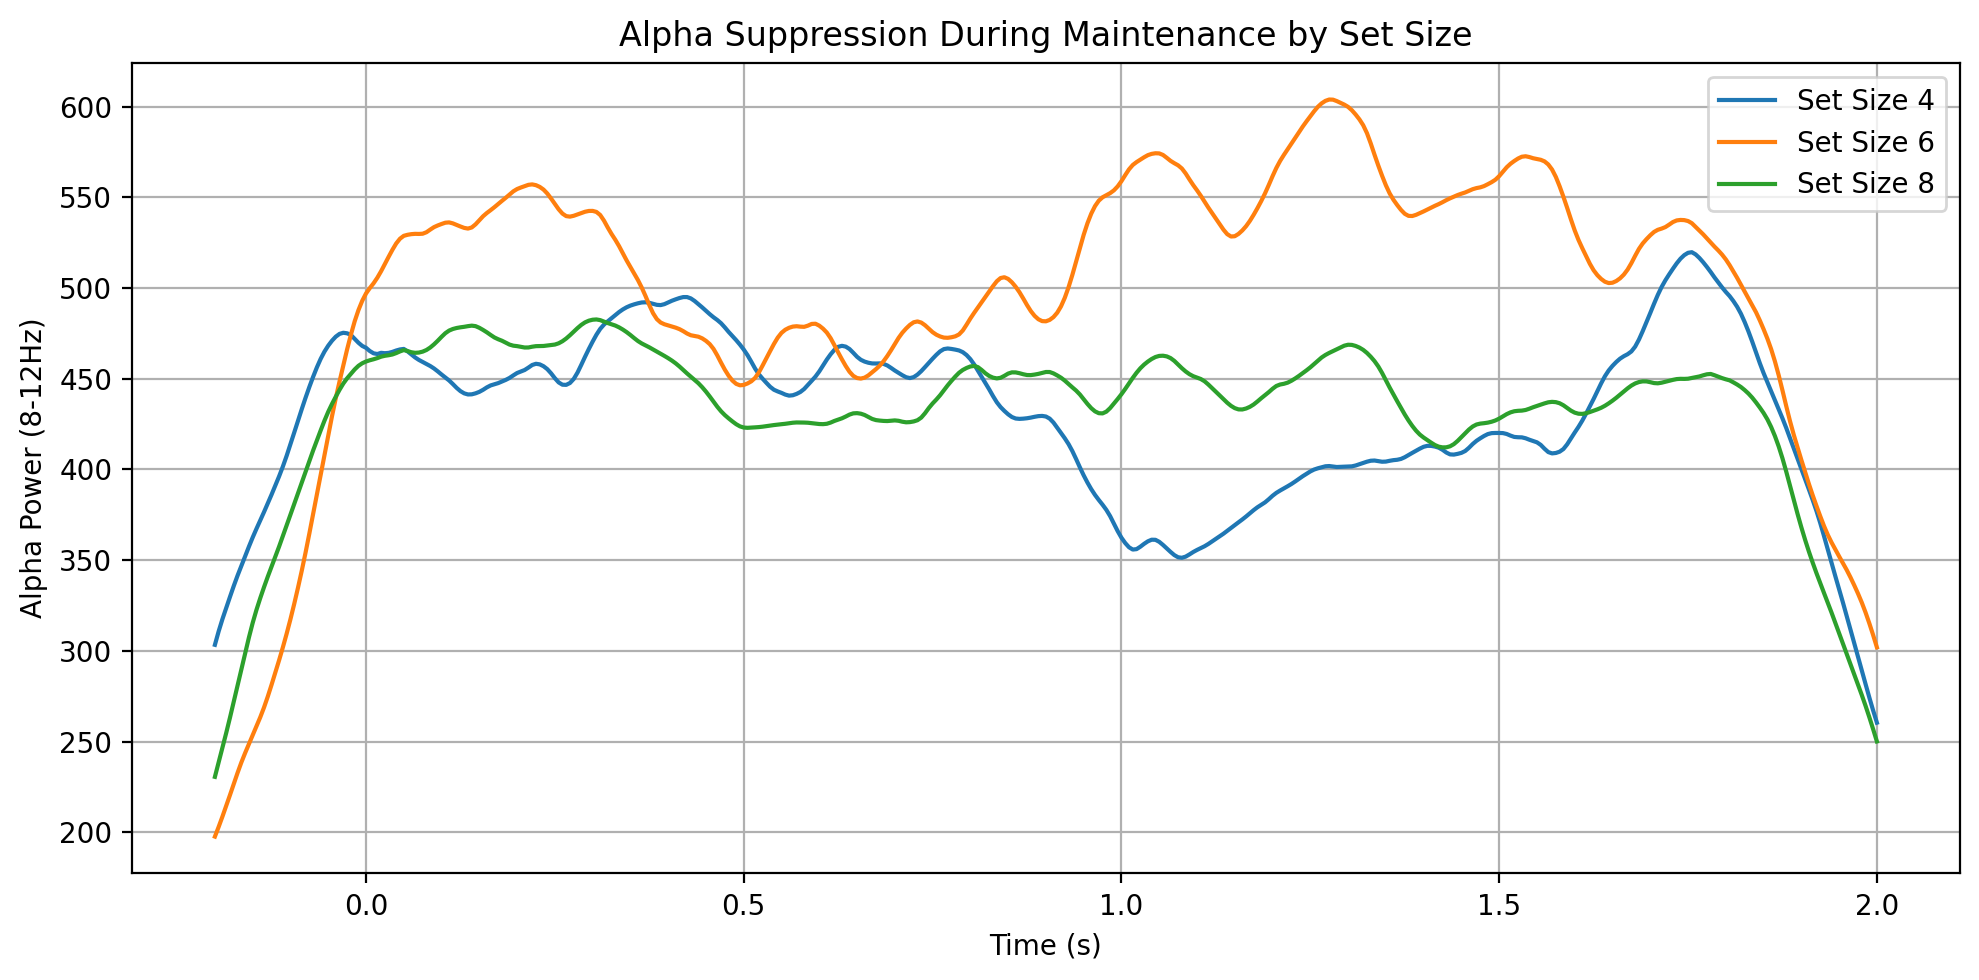

In [21]:
alpha_channels = ['Pz', 'P3', 'O1']

a4_picked, a4_avg = get_picked_maint_tfr(epochs4, 8, 12, alpha_channels)
a6_picked, a6_avg = get_picked_maint_tfr(epochs6, 8, 12, alpha_channels)
a8_picked, a8_avg = get_picked_maint_tfr(epochs8, 8, 12, alpha_channels)

fig_a = plt.figure(figsize=(10, 5))
plt.plot(a4_picked.times, a4_avg, label = 'Set Size 4')
plt.plot(a4_picked.times, a6_avg, label = 'Set Size 6')
plt.plot(a4_picked.times, a8_avg, label = 'Set Size 8')

plt.ylabel('Alpha Power (8-12Hz)')
plt.xlabel('Time (s)')
plt.title('Alpha Suppression During Maintenance by Set Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
fig_a

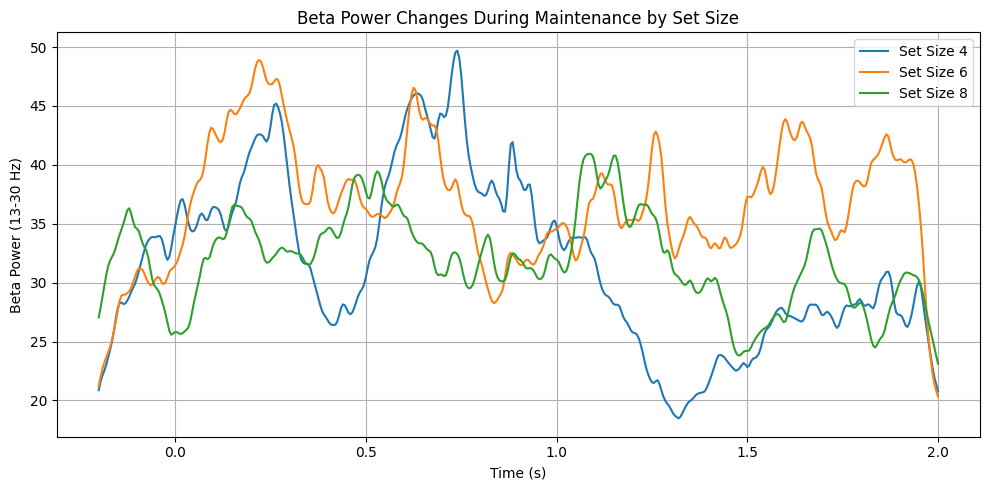

In [22]:
beta_channels = ['Cz']

b4_picked, b4_avg = get_picked_maint_tfr(epochs4, 13, 30, beta_channels)
b6_picked, b6_avg = get_picked_maint_tfr(epochs6, 13, 30, beta_channels)
b8_picked, b8_avg = get_picked_maint_tfr(epochs8, 13, 30, beta_channels)

fig_b = plt.figure(figsize=(10, 5))
plt.plot(b4_picked.times, b4_avg, label = 'Set Size 4')
plt.plot(b4_picked.times, b6_avg, label = 'Set Size 6')
plt.plot(b4_picked.times, b8_avg, label = 'Set Size 8')

plt.ylabel('Beta Power (13-30 Hz)')
plt.xlabel('Time (s)')
plt.title('Beta Power Changes During Maintenance by Set Size')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig_b

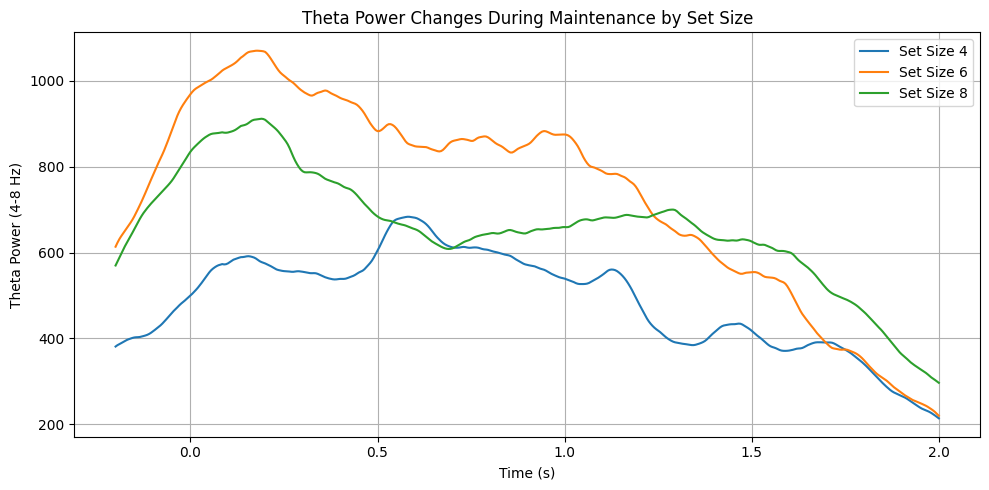

In [23]:
theta_channels = ['Fz']

t4_picked, t4_avg = get_picked_maint_tfr(epochs4, 4, 8, theta_channels)
t6_picked, t6_avg = get_picked_maint_tfr(epochs6, 4, 8, theta_channels)
t8_picked, t8_avg = get_picked_maint_tfr(epochs8, 4, 8, theta_channels)

fig_t = plt.figure(figsize=(10, 5))
plt.plot(t4_picked.times, t4_avg, label = 'Set Size 4')
plt.plot(t4_picked.times, t6_avg, label = 'Set Size 6')
plt.plot(t4_picked.times, t8_avg, label = 'Set Size 8')

plt.ylabel('Theta Power (4-8 Hz)')
plt.xlabel('Time (s)')
plt.title('Theta Power Changes During Maintenance by Set Size')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig_t

The data plots of alpha, beta, and theta frequency bands show no conclusive evidence that power levels are correlated to set size during maintenance rehearsal.

## 5. iEEG: Understanding Data
### 5.1 Loading Data and Setting Montage
The loading of data is similar to loading EEG data, with the exception of having an extra electrode dataset. This extra tsv probed me to check whether the locations of the electrodes have already been set in the RAW data. Realising that it was not preset, I manually created a dictionary of coordinates from the table to be made into a montage, locating the x, y, and z coordinates of the various intracranial electrodes.

In [24]:
iraw = mne.io.read_raw_edf('ds004752/sub-01/ses-04/ieeg/sub-01_ses-04_task-verbalWM_run-01_ieeg.edf', preload=True)
iev = pd.read_csv('ds004752/sub-01/ses-04/ieeg/sub-01_ses-04_task-verbalWM_run-01_events.tsv', sep='\t')
iel = pd.read_csv('ds004752/sub-01/ses-04/ieeg/sub-01_ses-04_task-verbalWM_run-01_electrodes.tsv', sep='\t')
ich = pd.read_csv('ds004752/sub-01/ses-04/ieeg/sub-01_ses-04_task-verbalWM_run-01_channels.tsv', sep='\t')

In [25]:
iel.head()

name          x          y          z  size  \
0  mAHL1 -25.199085 -12.875392 -14.791694   1.3   
1  mAHL2 -30.487097 -12.121593 -14.970046   1.3   
2  mAHL3 -36.703549 -11.769071 -16.076100   1.3   
3  mAHL4 -41.896864 -10.395350 -17.070944   1.3   
4  mAHL5 -47.161017  -9.481985 -18.043982   1.3   

                                  AnatomicalLocation  
0  Hipp, Left Hippocampus rHipp, rostral hippocampus  
1  Hipp, Left Hippocampus rHipp, rostral hippocampus  
2                                     no_label_found  
3                                     no_label_found  
4  STG, Left Superior Temporal Gyrus A22r, rostra...

In [26]:
print(iraw.info['chs'][iraw.ch_names.index('mAHL1')]['loc'])

[nan nan nan nan nan nan nan nan nan nan nan nan]


In [27]:
coords = {}

for _, row in iel.iterrows():
    coords[row['name']] = np.array([row['x']/1000, row['y']/1000, row['z']/1000])

montage = mne.channels.make_dig_montage(ch_pos = coords, coord_frame='head')

iraw.set_montage(montage)

iraw.info['chs'][iraw.ch_names.index('mAHL1')]['loc']

array([-0.02519908, -0.01287539, -0.01479169,  0.        ,  0.        ,
        0.        ,         nan,         nan,         nan,         nan,
               nan,         nan])

### 5.2 Reading Data and Checking for Null Values
This section does the same thing as was done with EEG data, with the exception of the extra electrode dataset.

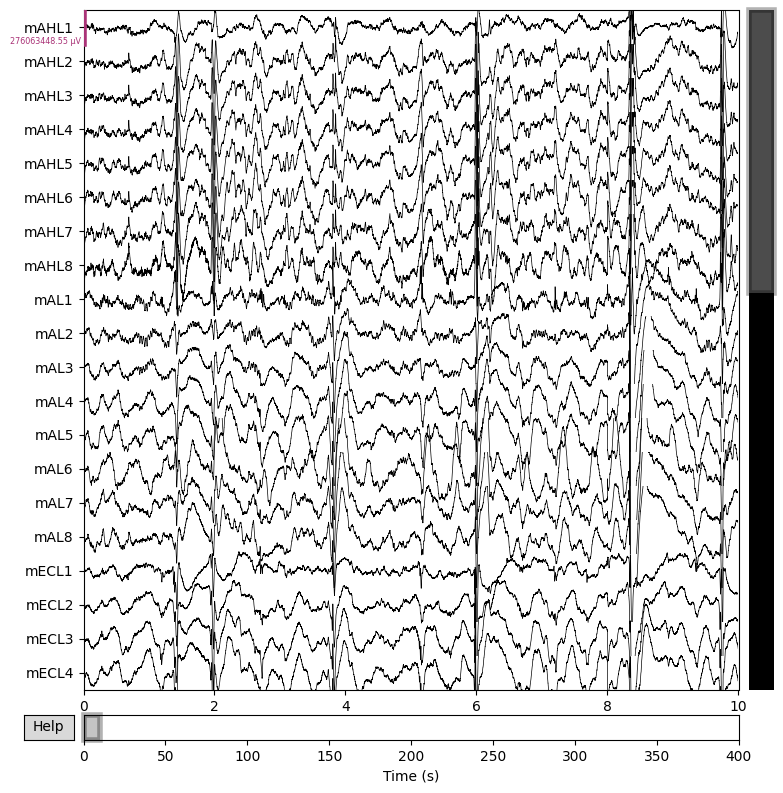

In [28]:
iraw.plot(scalings='auto')

In [29]:
iev.head()

onset  duration  nTrial  begSample  endSample  SetSize ProbeLetter Match  \
0   0.0005         8       1          1      16000        8           W    IN   
1   8.0005         8       2      16001      32000        6           K    IN   
2  16.0005         8       3      32001      48000        8           P    IN   
3  24.0005         8       4      48001      64000        4           W   OUT   
4  32.0005         8       5      64001      80000        4           P    IN   

   Correct  ResponseTime  Artifact  
0        1      1.178125         1  
1        1      1.400250         0  
2        1      1.293250         0  
3        1      1.422375         0  
4        1      0.918375         0

In [30]:
iev[iev.isnull()].count()

onset           0
duration        0
nTrial          0
begSample       0
endSample       0
SetSize         0
ProbeLetter     0
Match           0
Correct         0
ResponseTime    0
Artifact        0
dtype: int64

In [31]:
iel[iel.isnull()].count()

name                  0
x                     0
y                     0
z                     0
size                  0
AnatomicalLocation    0
dtype: int64

In [32]:
ich.head()

name  type units  low_cutoff  high_cutoff  sampling_frequency
0  mAHL1  SEEG    μV        1000          0.5                2000
1  mAHL2  SEEG    μV        1000          0.5                2000
2  mAHL3  SEEG    μV        1000          0.5                2000
3  mAHL4  SEEG    μV        1000          0.5                2000
4  mAHL5  SEEG    μV        1000          0.5                2000

In [33]:
ich[ich.isnull()].count()

name                  0
type                  0
units                 0
low_cutoff            0
high_cutoff           0
sampling_frequency    0
dtype: int64

## 6. iEEG: Preprocessing
This section is largely similar to the preprocessing of EEG data, just without ICA. Since the electrodes are intracranial, is it unlikely that eye or muscles artifacts present. The data is first filtered to the desired range and then epoched similar to how it was done with EEG data.

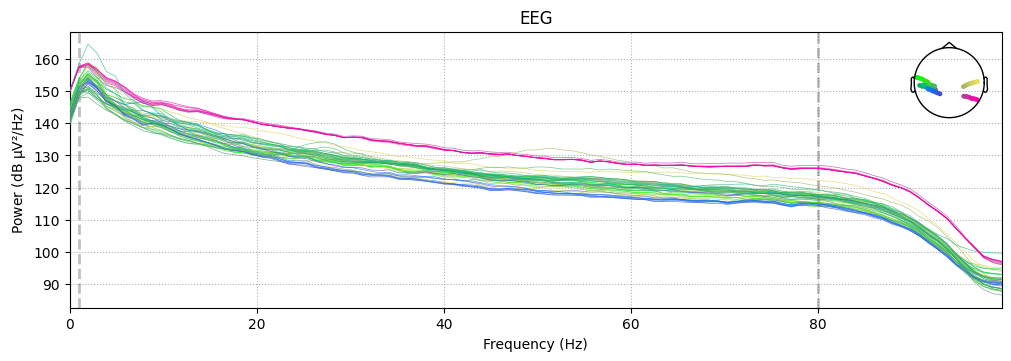

In [34]:
iraw.filter(1, 80)
iraw.set_eeg_reference('average')
iraw.plot_psd(fmax=100)

In [35]:
iev.head()

onset  duration  nTrial  begSample  endSample  SetSize ProbeLetter Match  \
0   0.0005         8       1          1      16000        8           W    IN   
1   8.0005         8       2      16001      32000        6           K    IN   
2  16.0005         8       3      32001      48000        8           P    IN   
3  24.0005         8       4      48001      64000        4           W   OUT   
4  32.0005         8       5      64001      80000        4           P    IN   

   Correct  ResponseTime  Artifact  
0        1      1.178125         1  
1        1      1.400250         0  
2        1      1.293250         0  
3        1      1.422375         0  
4        1      0.918375         0

In [36]:
iev4 = iev[(iev['SetSize'] == 4) & (iev['Artifact'] == 0)]
iev6 = iev[(iev['SetSize'] == 6) & (iev['Artifact'] == 0)]
iev8 = iev[(iev['SetSize'] == 8) & (iev['Artifact'] == 0)]

isamp_freq = iraw.info['sfreq']
ievent_id_4 = {'encoding': 14, 'maintenance': 24, 'probe': 34}
ievent_id_6 = {'encoding': 16, 'maintenance': 26, 'probe': 36}
ievent_id_8 = {'encoding': 18, 'maintenance': 28, 'probe': 38}

ievents_4 = get_events(iev4, 4)
ievents_6 = get_events(iev6, 6)
ievents_8 = get_events(iev8, 8)

iepochs4 = get_epochs(ievents_4, ievent_id_4, iraw)
iepochs6 = get_epochs(ievents_6, ievent_id_6, iraw)
iepochs8 = get_epochs(ievents_8, ievent_id_8, iraw)

print(iepochs4, iepochs6, iepochs8)

<Epochs | 33 events (all good), -0.2 – 2 s (baseline -0.2 – 0 s), ~53.3 MB, data loaded,
 'encoding': 11
 'maintenance': 11
 'probe': 11> <Epochs | 33 events (all good), -0.2 – 2 s (baseline -0.2 – 0 s), ~53.3 MB, data loaded,
 'encoding': 11
 'maintenance': 11
 'probe': 11> <Epochs | 60 events (all good), -0.2 – 2 s (baseline -0.2 – 0 s), ~96.8 MB, data loaded,
 'encoding': 20
 'maintenance': 20
 'probe': 20>


## 7. iEEG: Analysis
The channels picked, unlike EEG data which were labelled according to the 10-20 system, are all labelled uniquely depending on where they are placed in the head. Since the names are all present in the electrode dataset, we filter for the hippocampus, superior temporal gyrus, and inferior temporal gyrus which are known to commonly activate during verbal WM tasks.

Alpha, beta, and theta frequency bins are established and power/time plots are created in attempt to notice any significant correlations between set size and the scaling of cognitive load during maintenance.

In [37]:
picked_channels = []

for _, rows in iel.iterrows():
    loc_label = rows['AnatomicalLocation']
    if loc_label[:4] == 'Hipp':
        picked_channels.append(rows['name'])
    elif loc_label[:3] == 'STG':
        picked_channels.append(rows['name'])
    elif loc_label[:3] == 'MTG':
        picked_channels.append(rows['name'])
    else:
        continue

def get_picked_imaint_tfr(epochs, highpass, lowpass):
    maint = epochs['maintenance'].copy()
    tfr = mne.time_frequency.tfr_multitaper(maint, freqs = np.arange(highpass, lowpass, 1), n_cycles = 4, return_itc = False)
    picked = tfr.copy().pick_channels(picked_channels)
    ch_avg = picked.data.mean(axis=0)
    power_avg = ch_avg[(picked.freqs >= highpass) & (picked.freqs <= lowpass)].mean(axis=0)
    return picked, power_avg

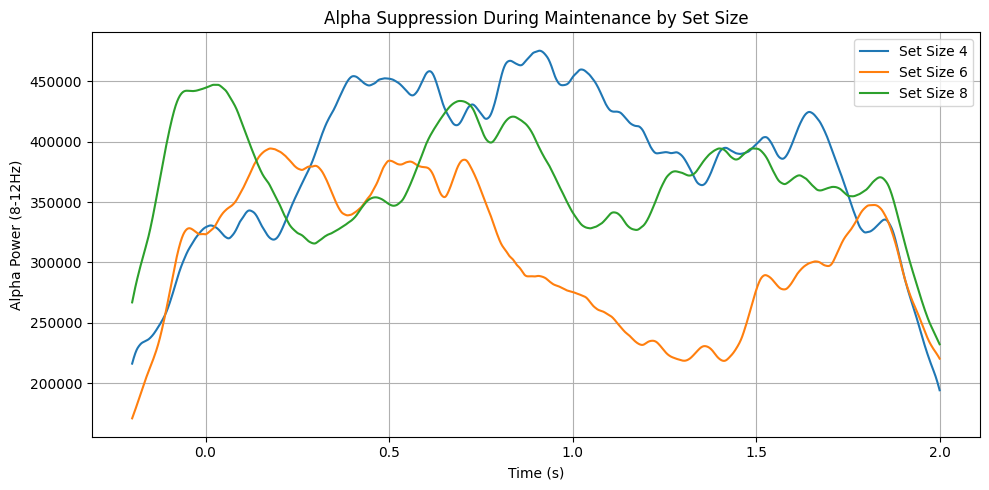

In [38]:
ia4_picked, ia4_avg = get_picked_imaint_tfr(iepochs4, 8, 12)
ia6_picked, ia6_avg = get_picked_imaint_tfr(iepochs6, 8, 12)
ia8_picked, ia8_avg = get_picked_imaint_tfr(iepochs8, 8, 12)

ia_fig = plt.figure(figsize = (10, 5))
plt.plot(ia4_picked.times, ia4_avg, label = 'Set Size 4')
plt.plot(ia4_picked.times, ia6_avg, label = 'Set Size 6')
plt.plot(ia4_picked.times, ia8_avg, label = 'Set Size 8')

plt.xlabel('Time (s)')
plt.ylabel('Alpha Power (8-12Hz)')
plt.title('Alpha Suppression During Maintenance by Set Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
ia_fig

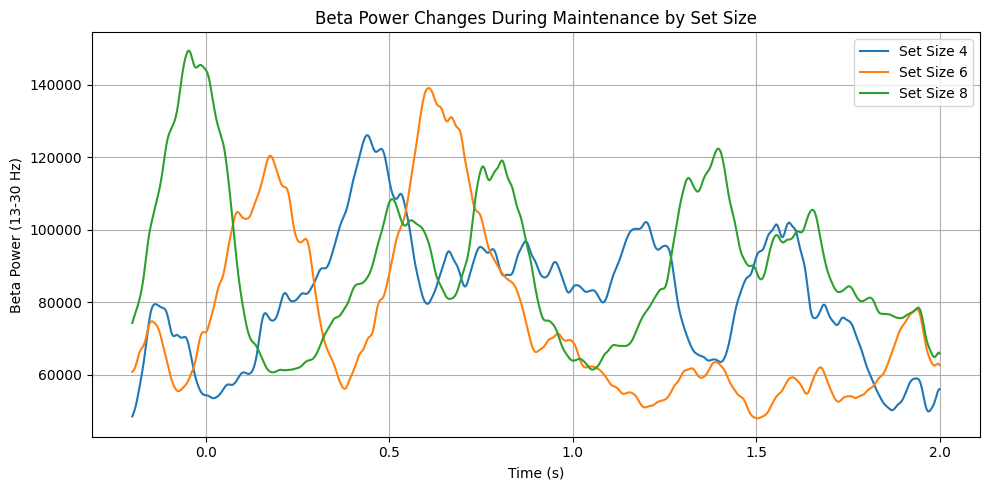

In [39]:
ib4_picked, ib4_avg = get_picked_imaint_tfr(iepochs4, 13, 30)
ib6_picked, ib6_avg = get_picked_imaint_tfr(iepochs6, 13, 30)
ib8_picked, ib8_avg = get_picked_imaint_tfr(iepochs8, 13, 30)

ib_fig = plt.figure(figsize=(10, 5))
plt.plot(ib4_picked.times, ib4_avg, label = 'Set Size 4')
plt.plot(ib4_picked.times, ib6_avg, label = 'Set Size 6')
plt.plot(ib4_picked.times, ib8_avg, label = 'Set Size 8')

plt.ylabel('Beta Power (13-30 Hz)')
plt.xlabel('Time (s)')
plt.title('Beta Power Changes During Maintenance by Set Size')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
ib_fig

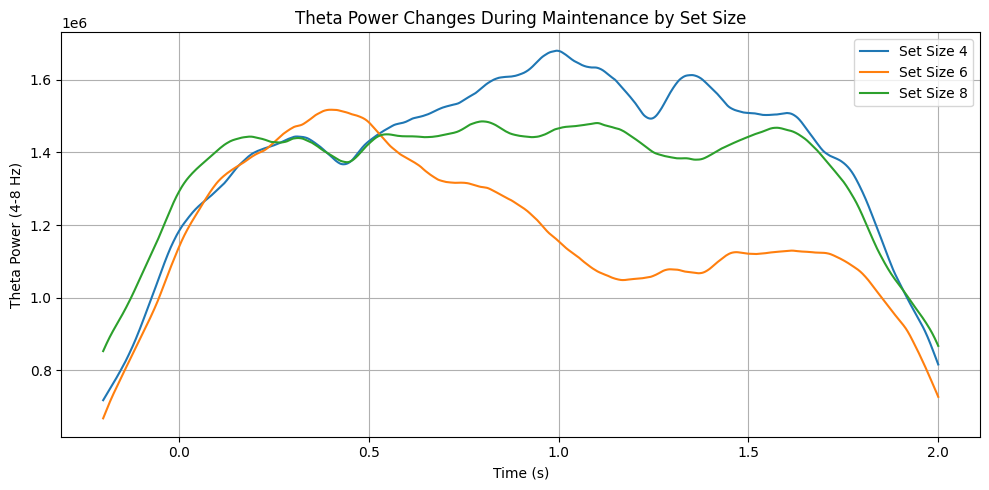

In [40]:
it4_picked, it4_avg = get_picked_imaint_tfr(iepochs4, 4, 8)
it6_picked, it6_avg = get_picked_imaint_tfr(iepochs6, 4, 8)
it8_picked, it8_avg = get_picked_imaint_tfr(iepochs8, 4, 8)

it_fig = plt.figure(figsize=(10, 5))
plt.plot(it4_picked.times, it4_avg, label = 'Set Size 4')
plt.plot(it4_picked.times, it6_avg, label = 'Set Size 6')
plt.plot(it4_picked.times, it8_avg, label = 'Set Size 8')

plt.ylabel('Theta Power (4-8 Hz)')
plt.xlabel('Time (s)')
plt.title('Theta Power Changes During Maintenance by Set Size')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
it_fig

The plots above showcasing different frequency bands still provide little conclusive evidence that cognitive load scales with set size.

## 8. Conclusion
Considering that this was only an analysis of a single session, there was little confidence that identifiable markers of cognitive load scaling could be obtained from the EEG data due to the potential noise present and the inability to average the noise out since there were too few trials. However, it is slightly surprising that iEEG data could also provide little conclusive evidence to cognitive load scaling with set size. This leads me to prematurely postulate certain limitations which could provide unsolvable blind spots in the dataset:

1. Lack of stim channels in raw EEG and iEEG data.
2. Unclear event markers between task description and event dataset information.

Additional limitations could be montages not set beforehand, coupled with inexperience in manually transferring coordinates over which could muddle the process (although they should theoretically only affect topological plots which would only be critical when performing ICA. Using a preset ```standard_1010``` montage for EEG data should not create an issue and the potential issue. While iEEG data required manually attaching coordinates to each electrode, there was minimal topological preprocessing or analysis, and should also not provide an issue).

This exprimental single session notebook will come to a close at this juncture. Hopefully, I will have more luck creating an EEG data pipeline, utilising the ```autoreject``` library.